### Import Modules

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 1.13.1


### Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [32]:
data = pd.read_csv("D://Named_Entity_Recognition//ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [33]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [34]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [35]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Retrieve Sentences and Corresponsing Tags

In [36]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [37]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [38]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [39]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [40]:
word2idx, tag2idx

({'lawfully': 1,
  'alleges': 2,
  'Hamid': 3,
  'Zimbabweans': 4,
  'Ahnlund': 5,
  'wit': 6,
  'Milorad': 7,
  'Sevan': 8,
  'annoyed': 9,
  "Sh'ite": 10,
  'Bosnia-Herzegovina': 11,
  'Buro': 12,
  'GBAGBO': 13,
  'Music': 14,
  'Aleksander': 15,
  'Dejan': 16,
  'Jiang': 17,
  'stillborn': 18,
  '101st': 19,
  'Sudharmono': 20,
  'long-haul': 21,
  'cost-reduction': 22,
  'Booker': 23,
  'gardening': 24,
  'Navy': 25,
  'Harriet': 26,
  'massed': 27,
  'soundly': 28,
  'ceremonial': 29,
  'related': 30,
  'rout': 31,
  'contemptuously': 32,
  'Enough': 33,
  'Zim': 34,
  'economic': 35,
  'At': 36,
  'speed': 37,
  'masterminds': 38,
  'brace': 39,
  'risks': 40,
  'Trondheim': 41,
  'Farm': 42,
  'pole': 43,
  '464': 44,
  'Unpredictable': 45,
  'explicit': 46,
  'etched': 47,
  'costing': 48,
  'cosily': 49,
  'geographic': 50,
  'testifying': 51,
  'Sgrena': 52,
  '1852': 53,
  'lecture': 54,
  '1,64,000': 55,
  'Dana': 56,
  'Section': 57,
  'sabotaging': 58,
  'Koss': 59,
  'S

### Padding Input Sentences and Creating Train/Test Splits

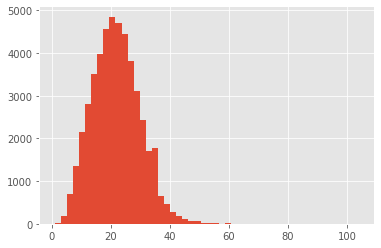

In [41]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build and Compile a Bidirectional LSTM Model

In [48]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [49]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

###  Train the Model

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [52]:
y = np.array(y_train)
y.shape

(38367, 50, 17)

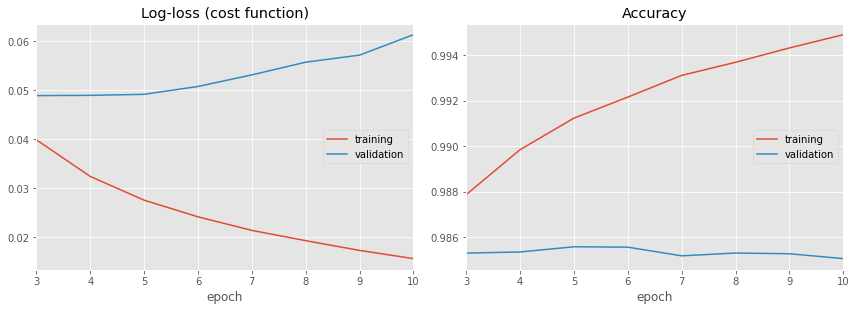

Log-loss (cost function):
training   (min:    0.016, max:    0.210, cur:    0.016)
validation (min:    0.049, max:    0.075, cur:    0.061)

Accuracy:
training   (min:    0.953, max:    0.995, cur:    0.995)
validation (min:    0.979, max:    0.986, cur:    0.985)

Epoch 00010: val_loss did not improve from 0.04890
30693/30693 [==============================] - 104s 3ms/sample - loss: 0.0156 - acc: 0.9949 - val_loss: 0.0614 - val_acc: 0.9851
Wall time: 17min 18s


In [53]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=np.array(y_train),
    validation_split=0.2,
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


### Evaluate Named Entity Recognition Model

In [55]:
model.evaluate(x_test, np.array(y_test))

9592/9592 [==============================] - 4s 447us/sample - loss: 0.0647 - acc: 0.9848


[0.06469203315495053, 0.9847769]

In [61]:
i = np.random.randint(0, x_test.shape[0]) 
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	B-org
Associated     B-org	I-org
Press          I-org	I-org
reports        O	O
the            O	O
Palestinian    B-gpe	B-gpe
Authority      O	O
said           O	O
Mr.            B-per	B-per
Mashaal        B-geo	I-per
's             O	O
statement      O	O
was            O	O
"              O	O
irresponsible  O	O
"              O	O
and            O	O
a              O	O
violation      O	O
of             O	O
the            O	O
truce          O	O
.              O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Tselem       O	O
B'Ts